In [1]:
cd /home

/home


# Astromer I vs Astromer II

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from glob import glob
import toml
import os

from sklearn.metrics import r2_score, mean_squared_error
from presentation.experiments.utils import get_clf_summary
from src.utils import get_metrics

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

2023-10-23 12:11:06.065809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


**WARNING**: This notebook was made to visualize classification results only. 

All the following blocks assume you already ran the script `./presentation/experiments/astromer_{1/2}/script.py`.

The directory looks like: 
- `presentation`
    - `astromer_1/results/<experiment_folder>`
        - `finetuning`
        - `classification`
        - `pretraining`
    - `astromer_2/results/<experiment_folder>`
        - `finetuning`
        - `classification`
        - `pretraining`

In [3]:
folders = [
    './presentation/experiments/astromer_0/results/',
     './presentation/experiments/astromer_1/results/',
]
tags = ['50\% Probed', '20\% Probed']

In [11]:
all_folders = []
for f in folders:
    all_folders+=glob(os.path.join(f, '*', '*'))
del all_folders[-3]
all_folders

['./presentation/experiments/astromer_0/results/bugstromer_clean/2023-10-19_18-40-56',
 './presentation/experiments/astromer_0/results/bugstromer/2023-10-16_14-06-03',
 './presentation/experiments/astromer_1/results/bugstromer_nc/2023-10-16_12-34-51',
 './presentation/experiments/astromer_1/results/vh_clean/2023-10-19_18-38-23',
 './presentation/experiments/astromer_1/results/vh_first_20/2023-10-17_12-29-02',
 './presentation/experiments/astromer_1/results/vh_first_20/2023-10-17_19-25-34',
 './presentation/experiments/astromer_1/results/bugstromer_nc_2/2023-10-21_23-06-54',
 './presentation/experiments/astromer_1/results/vh_first/2023-10-19_13-37-36',
 './presentation/experiments/astromer_1/results/vh_first/2023-10-14_16-57-22',
 './presentation/experiments/astromer_1/results/vh_first/2023-10-21_14-22-57',
 './presentation/experiments/astromer_1/results/vh_first/2023-10-20_03-11-38',
 './presentation/experiments/astromer_1/results/vh_first/2023-10-16_13-54-52',
 './presentation/experim

# Pretraining

In [12]:
rows = []
for f in all_folders:
    rmse_val = get_metrics(os.path.join(f, 'pretraining', 'logs', 'validation'), show_keys=False, metric_name='rmse')
    r2_val   = get_metrics(os.path.join(f, 'pretraining', 'logs', 'validation'), show_keys=False, metric_name='r_square')
            
    with open(os.path.join(f, 'pretraining', 'config.toml'), 'r') as handle:
        conf = toml.load(handle)
    conf['rmse'] = rmse_val['value'].min()
    conf['r2'] = r2_val['value'].max()
    try:
        r2_test = get_metrics(os.path.join(f, 'pretraining', 'logs', 'test'), show_keys=False, metric_name='r_square')
        conf['state'] = 'finished' 
    except:
        conf['state'] = 'running'
    conf['path'] = f.split('results/')[-1]
    rows.append(conf)

In [13]:
df = pd.DataFrame(rows)
filtered = df[['exp_name', 'probed', 'dropout', 'r2', 'rmse', 'scheduler', 'state', 'path']].sort_values('r2', ascending=False)
filtered.fillna('1e-3')

,exp_name,probed,dropout,r2,rmse,scheduler,state,path
1,bugstromer,0.5,0.0,0.8009453,0.14739424,True,finished,bugstromer/2023-10-16_14-06-03
6,bugstromer_nc_2,0.5,0.0,0.79672235,0.14909613,True,running,bugstromer_nc_2/2023-10-21_23-06-54
0,bugstromer_clean,0.5,0.0,0.7928149,0.07134047,True,finished,bugstromer_clean/2023-10-19_18-40-56
2,bugstromer_nc,0.5,0.0,0.76044,0.1617269,True,finished,bugstromer_nc/2023-10-16_12-34-51
3,vh_clean,0.2,0.0,0.74558926,0.07892094,True,finished,vh_clean/2023-10-19_18-38-23
12,v_first,0.5,0.0,0.7278124,0.17235895,1e-3,finished,v_first/2023-10-14_16-56-26
4,vh_first_20,0.2,0.0,0.72743356,0.17122485,True,finished,vh_first_20/2023-10-17_12-29-02
13,astromer_1,0.2,0.0,0.72050536,0.17322965,True,running,astromer_1/2023-10-22_19-00-02
9,vh_first,1.0,0.0,0.6377339,0.1994309,False,finished,vh_first/2023-10-21_14-22-57
14,astromer_1,0.5,0.0,0.6006451,0.20864727,True,finished,astromer_1/2023-10-21_23-07-40


Text(0, 0.5, 'R-square')

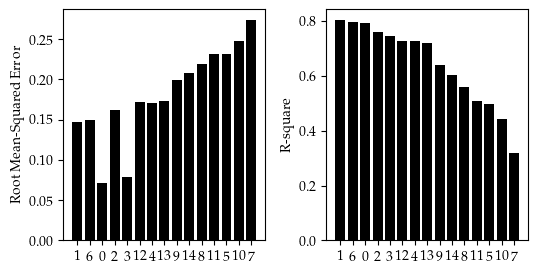

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=100, gridspec_kw={'wspace':.3})
x = filtered.index
axes[0].bar([str(xx) for xx in x], filtered.rmse, color='k')
axes[1].bar([str(xx) for xx in x], filtered.r2, color='k')

axes[0].set_ylabel('Root Mean-Squared Error')
axes[1].set_ylabel('R-square')

# Classification

In [58]:
'./presentation/experiments/astromer_1/results/astromer_1/2023-10-21_23-07-40/'

'./presentation/experiments/astromer_1/results/astromer_1/2023-10-21_23-07-40/'

In [59]:
rows = []
for f in all_folders:
    with open(os.path.join(f, 'pretraining', 'config.toml'), 'r') as handle:
        conf = toml.load(handle)
    for ds in ['alcock', 'atlas']:
        for ns in [20, 100]:
            for fold_n in range(3):
                for ft_name in ['', '_ft_allvisible', '_finetuning']:
                    try:
                        clf_path = os.path.join(f, 
                                                'classification'+ft_name, 
                                                ds, 
                                                'fold_{}'.format(fold_n), 
                                                '{}_{}'.format(ds, ns),
                                                'att_mlp',
                                                'metrics.toml') 
                        with open(clf_path, 'r') as handle:
                            metrics = toml.load(handle)
                            for key in metrics.keys():
                                metrics[key] = float(metrics[key])
                            metrics['dataset'] = ds
                            metrics['spc'] = ns
                            metrics['path'] = f.split('results/')[-1]
                            metrics['fold'] = fold_n
                            metrics['clf'] = 'att_mlp'
                            metrics['ft_name'] = 'allvisible' if ft_name == '_ft_allvisible' else 'masked'

                            rows.append(metrics)
                    except Exception as e:
                        continue
clf_summary = pd.DataFrame(rows)

In [60]:
clf_summary['ft_name'].unique()

array(['masked', 'allvisible'], dtype=object)

In [61]:
df_summary = clf_summary.groupby(['spc', 'dataset', 'clf', 'path', 'ft_name']).mean().reset_index()
df_summary_std = clf_summary.groupby(['spc', 'dataset', 'clf', 'path', 'ft_name']).std().reset_index()
df_summary_std = df_summary_std.rename(columns={'clf_val_acc':'std_val_acc', 
                                           'clf_val_loss':'std_val_loss',
                                           'clf_test_precision':'std_test_precision',
                                           'clf_test_recall':'std_test_recall',
                                           'clf_test_f1':'std_test_f1',
                                           'clf_test_acc':'std_test_acc'})
clf_summary = pd.merge(df_summary, df_summary_std, on=['spc', 'dataset', 'clf', 'path', 'ft_name'], how='right')

In [62]:
result = pd.merge(filtered, clf_summary, on="path", how="right")
result = result.fillna(False)
result['label'] = result.apply(lambda x: '{}_{}_{}_{}\n {}'.format(x['exp_name'],
                                         x['probed'],
                                         x['dropout'],
                                         'sch' if x['scheduler'] else '1e-3',
                                         x['ft_name']), axis=1)

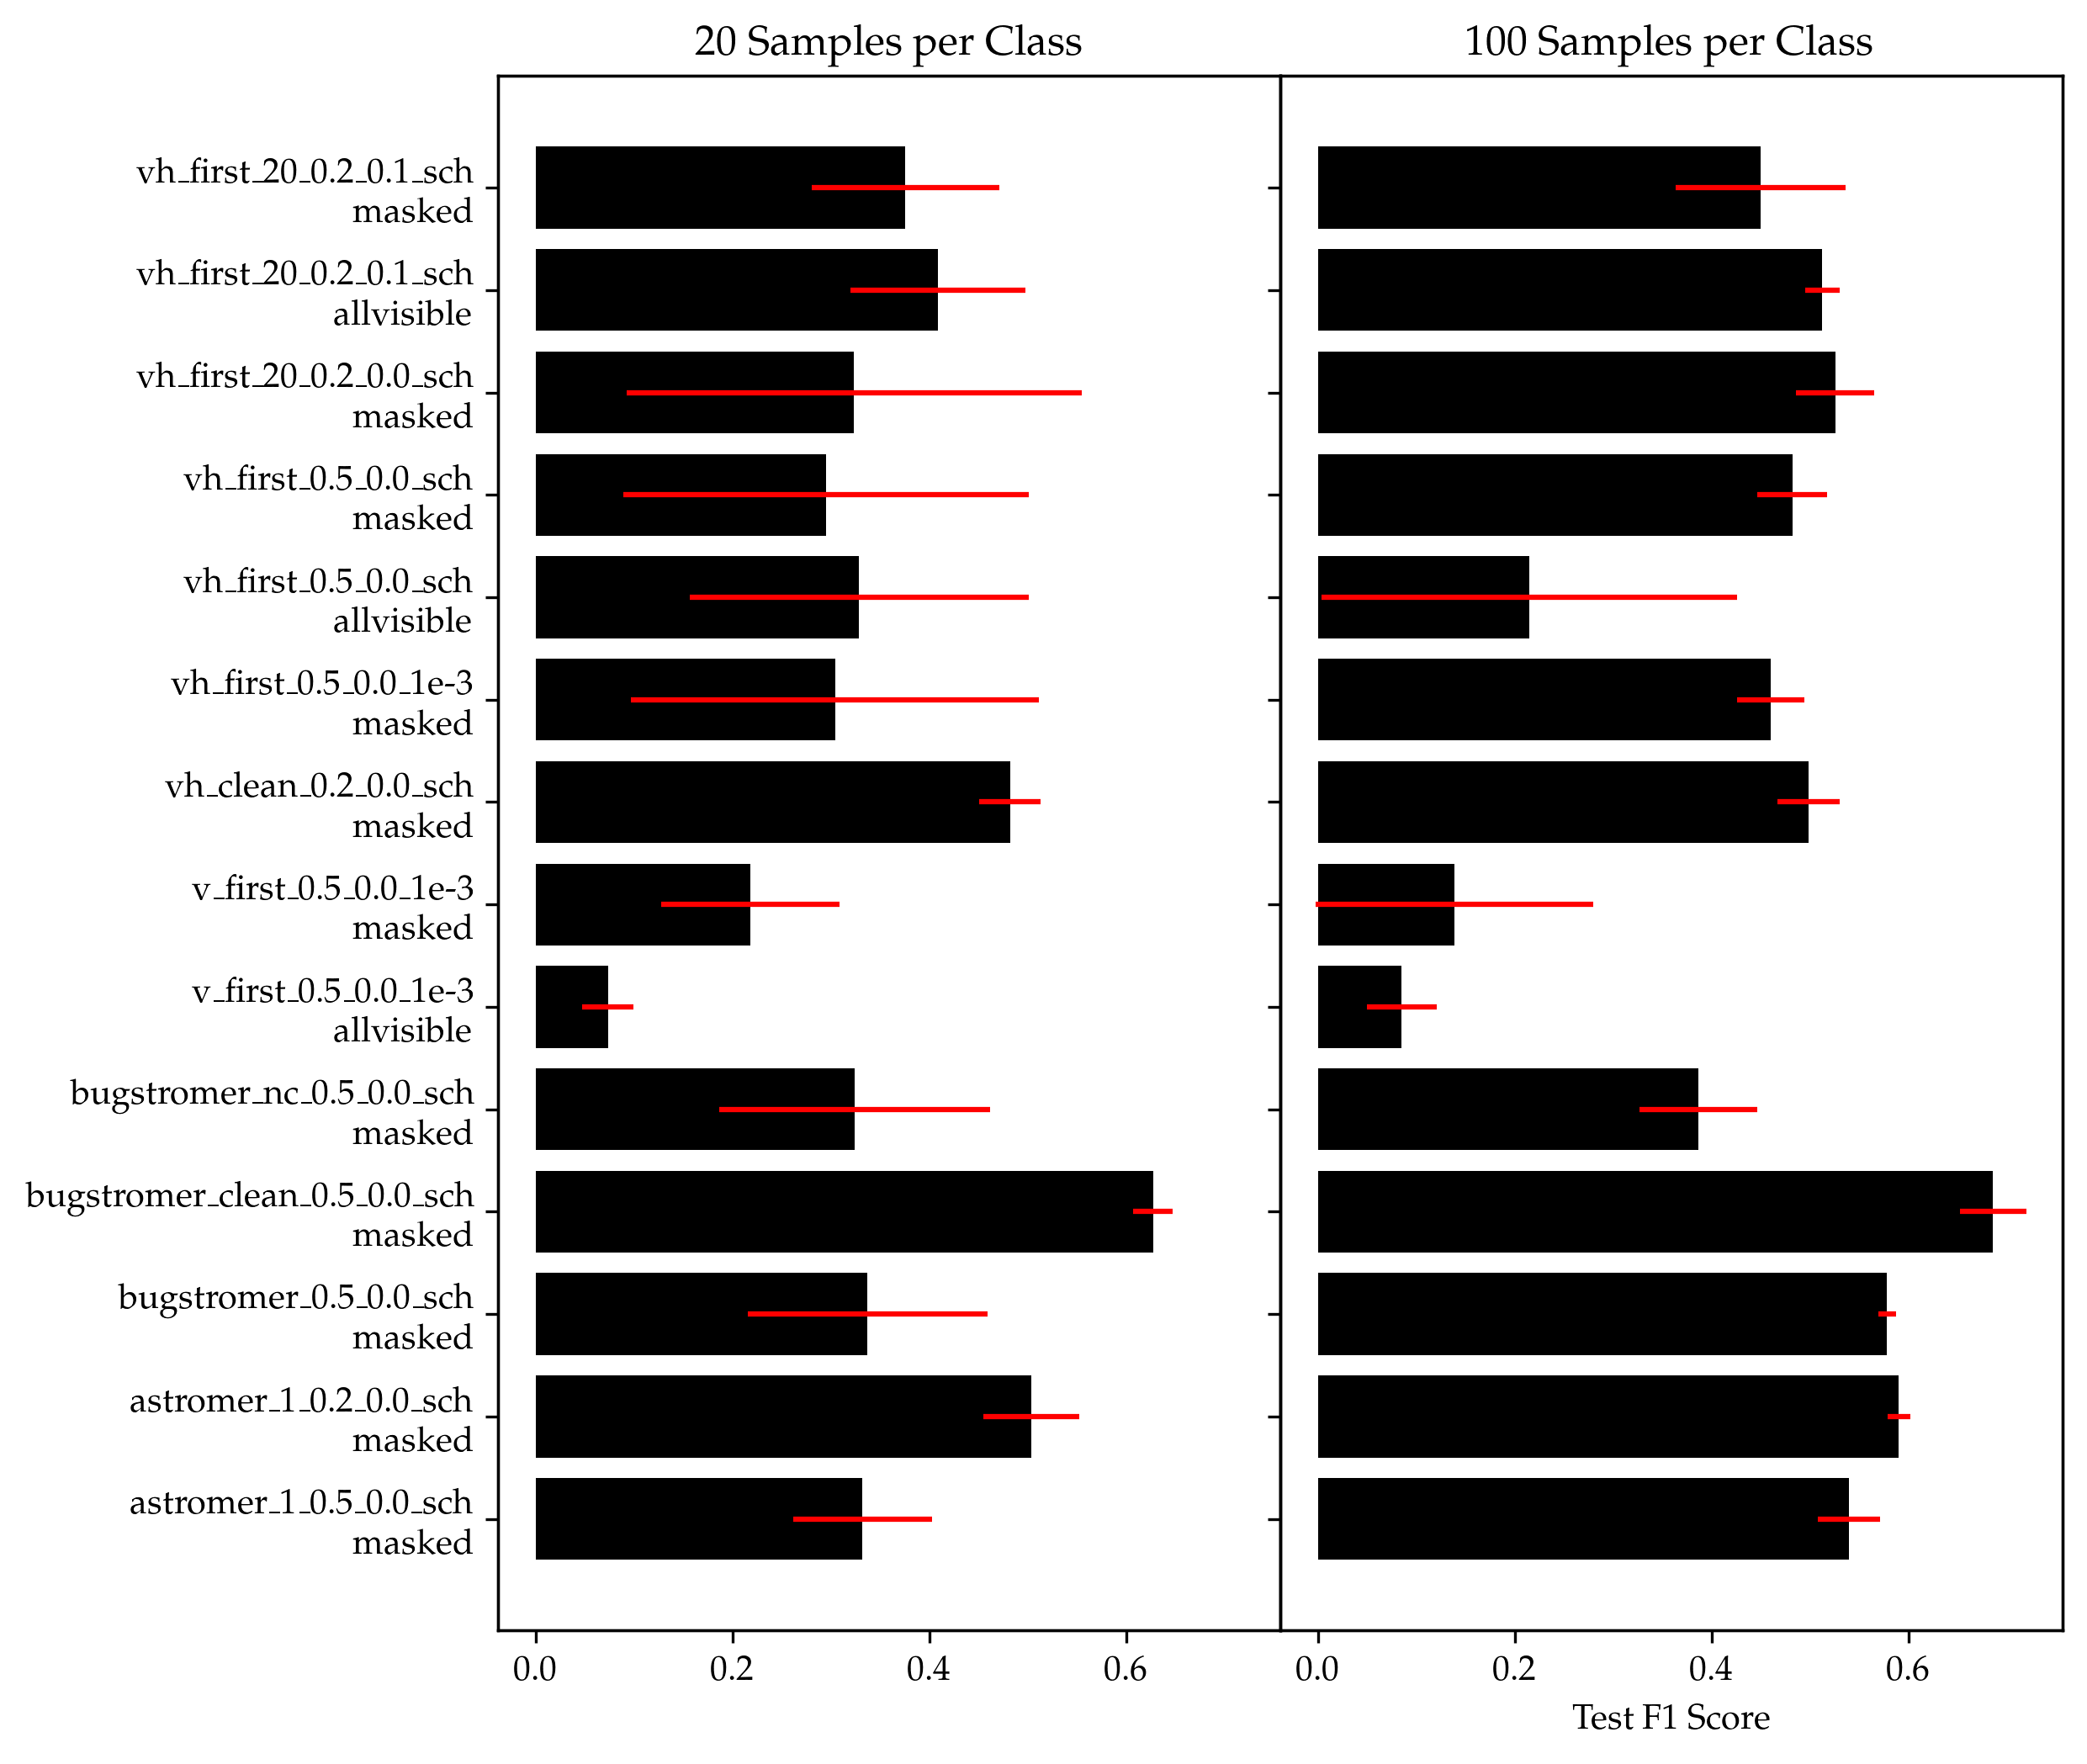

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharex=True, dpi=300, sharey=True, gridspec_kw={'wspace':0.0})

# axes[0].set_title('Alcock')
axes[-1].set_xlabel('Test F1 Score')
for k, spc in enumerate([20, 100]):
    y = result[(result['dataset'] == 'alcock') & (result['spc']==spc)]['clf_test_f1']
    y_err = result[(result['dataset'] == 'alcock') & (result['spc']==spc)]['std_test_f1']
    x = result[(result['dataset'] == 'alcock') & (result['spc']==spc)]['label']
    
    axes[k].barh(x, y, xerr=y_err, color='k', error_kw={'ecolor':'red'})
    axes[k].set_yticks(x)
    ax2 = axes[k].twinx()
    ax2.set_yticks([])
    ax2.set_title('{} Samples per Class'.format(spc))

    ax2.yaxis.tick_right()

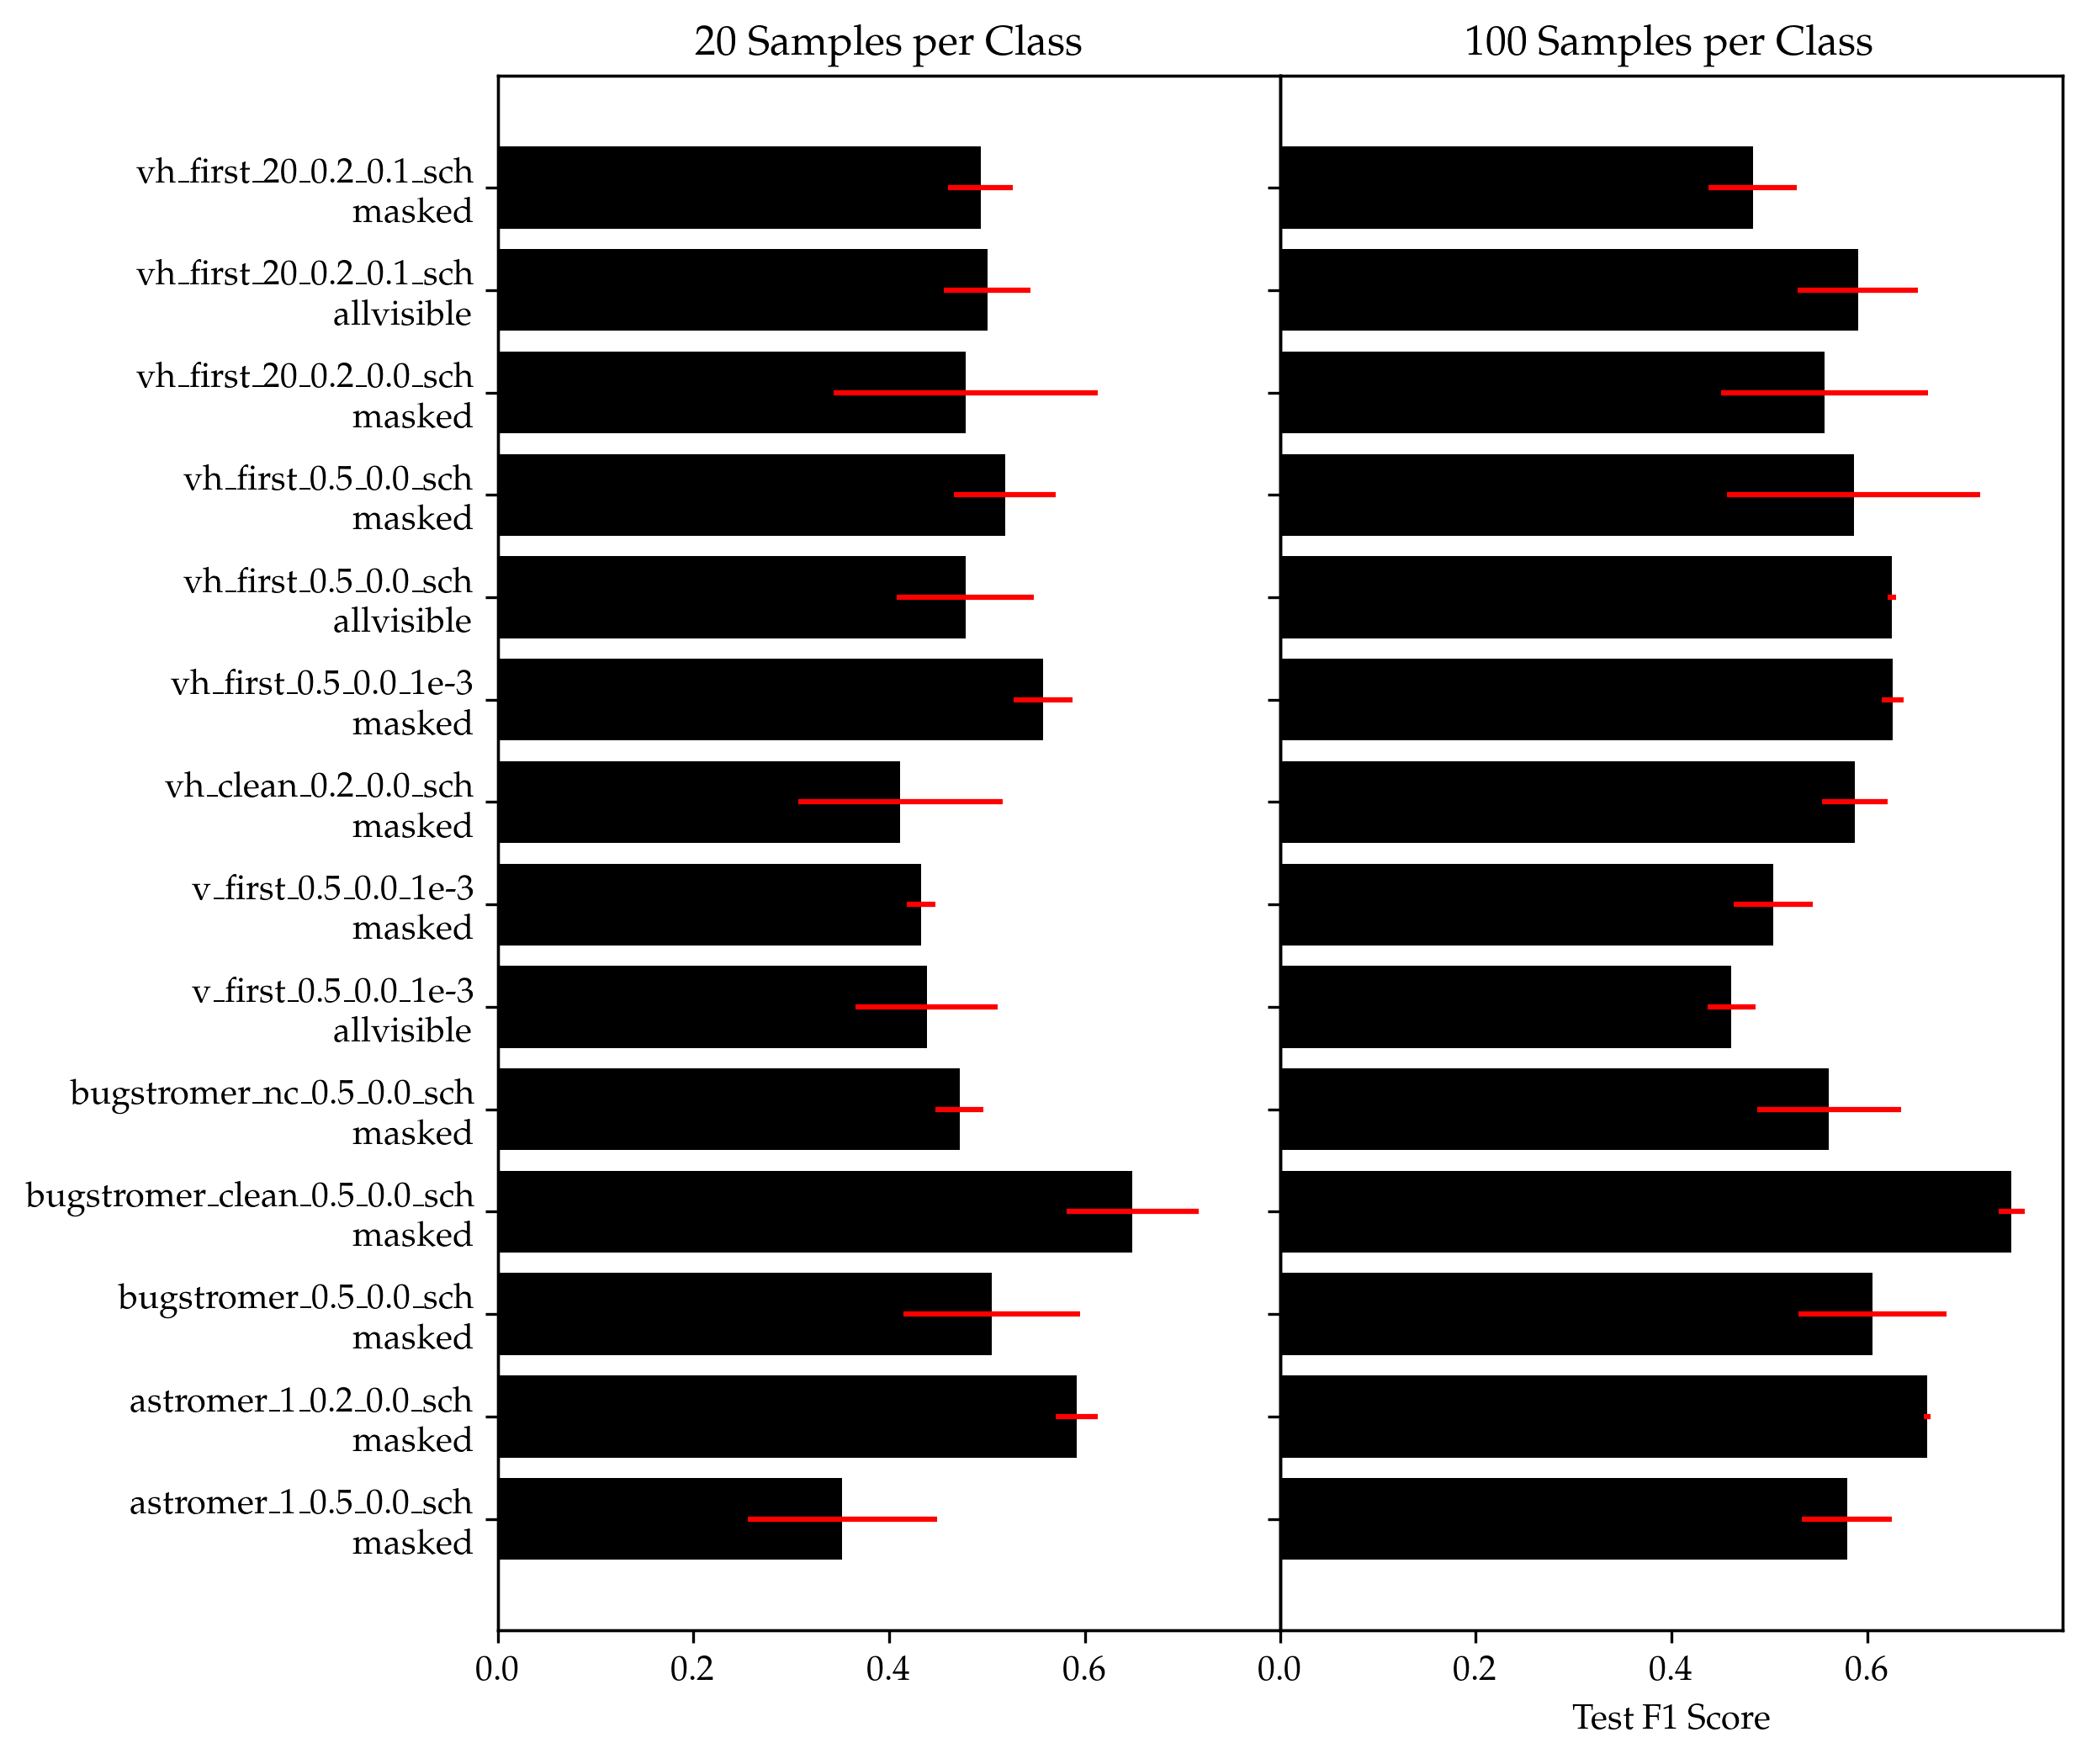

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharex=True, dpi=300, sharey=True, gridspec_kw={'wspace':0.0})
# axes[0].set_title('Atlas')
axes[-1].set_xlabel('Test F1 Score')
for k, spc in enumerate([20, 100]):
    y = result[(result['dataset'] == 'atlas') & (result['spc']==spc)]['clf_test_f1']
    y_err = result[(result['dataset'] == 'atlas') & (result['spc']==spc)]['std_test_f1']
    x = result[(result['dataset'] == 'atlas') & (result['spc']==spc)]['label']
    
    axes[k].barh(x, y, xerr=y_err, color='k', error_kw={'ecolor':'red'})
    axes[k].set_yticks(x)
    ax2 = axes[k].twinx()
    ax2.set_yticks([])
    ax2.set_title('{} Samples per Class'.format(spc))

    ax2.yaxis.tick_right()

In [55]:
columns_to_compare = ['clf_test_f1', 'rmse', 'r2']
# valid = result[result['spc']==100]
valid = valid[columns_to_compare].dropna().astype(float)

# valid

In [56]:
import seaborn as sns

valid.shape

(26, 3)

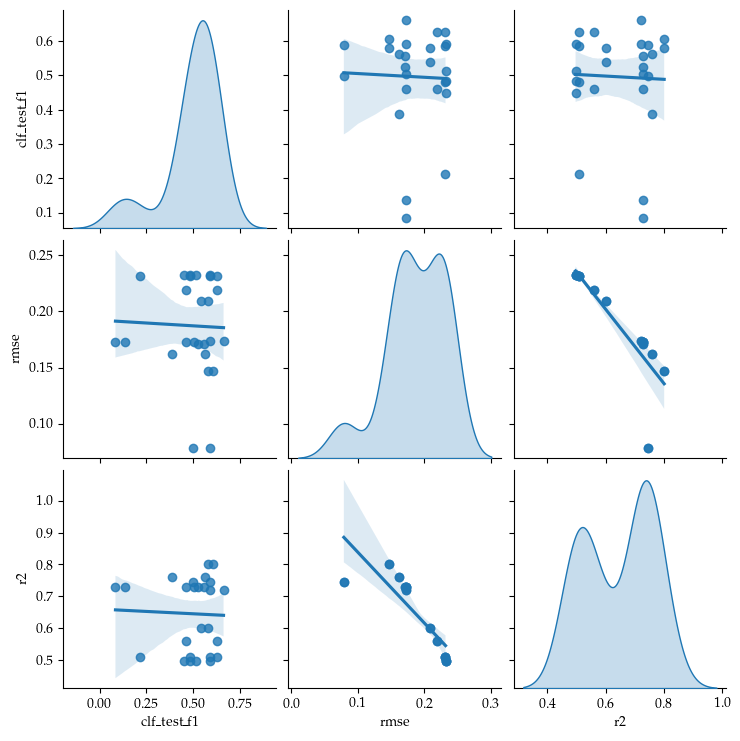

In [57]:
sns.pairplot(valid, vars=columns_to_compare, kind='reg', diag_kind='kde')